In [ ]:
#  https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables

'''
Looking at the Nasdaq data in the CNN-pred stock data. 

Used a variety of models to predict the percent change in the close price for NASDAQ. Took out the seasonal fluctuation in 
the data to smoothen it out.. then tried to predict the percent change. 

Also used a time series version of cross validation to pick out the best model. Best I found was an R^2 of around 0.32 or so.

'''


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import datetime 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
filename_prefix = 'C://Users/Tim/Downloads/CNNpred'

djiDF = pd.read_csv(filename_prefix + '/Processed_DJI.csv', index_col = 'Date', parse_dates = True)
nasdaqDF = pd.read_csv(filename_prefix + '/Processed_NASDAQ.csv', index_col = 'Date', parse_dates = True)
nyseDF = pd.read_csv(filename_prefix + '/Processed_NYSE.csv', index_col = 'Date', parse_dates = True)
russellDF = pd.read_csv(filename_prefix + '/Processed_RUSSELL.csv', index_col = 'Date', parse_dates = True)
spDF = pd.read_csv(filename_prefix + '/Processed_S&P.csv', index_col = 'Date', parse_dates = True)

In [3]:
n = 19 # not TE1, TE2, TE3, DE1, DE2, DE4, DE5, DE6

not_null_cols = nasdaqDF.columns[:19]

dataDF = nasdaqDF.dropna(subset = not_null_cols).fillna(nasdaqDF.mean()) #.fillna(-100)

In [4]:
dataDF

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-15,2468.770020,0.108347,0.013710,-0.002396,0.009641,0.006489,2.783623,4.134557,3.676689,6.614236,...,0.01,-1.72,-0.58,0.13,0.35,0.51,0.51,-0.30,-1.30,-0.88
2010-10-18,2480.659912,-0.227561,0.004816,0.013710,-0.002396,0.009641,3.260578,5.806728,4.679352,5.298762,...,0.17,0.92,0.61,0.28,0.07,-0.17,-0.14,-2.05,0.25,0.05
2010-10-19,2436.949951,0.299836,-0.017620,0.004816,0.013710,-0.002396,0.787041,1.546771,2.410493,3.728685,...,-1.84,-2.59,-1.74,-1.23,1.27,1.66,1.62,-2.58,-4.14,-2.51
2010-10-20,2457.389893,-0.100395,0.008388,-0.017620,0.004816,0.013710,0.661958,3.223055,3.401127,5.261821,...,1.40,1.03,0.91,0.94,-1.01,-1.29,-1.29,2.52,2.44,0.82
2010-10-21,2459.669922,0.058861,0.000928,0.008388,-0.017620,0.004816,0.997382,3.188361,3.844002,5.697692,...,-0.98,-3.69,-0.53,0.09,0.64,0.28,0.32,-3.09,-3.26,-1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09,6750.049805,0.058830,-0.005755,0.003153,-0.002750,0.003252,0.522862,2.947790,2.194980,2.405216,...,-0.24,-0.62,-0.34,-0.27,-0.61,-0.44,-0.45,0.53,-0.26,0.32
2017-11-10,6750.939941,-0.116863,0.000132,-0.005755,0.003153,-0.002750,-0.199573,0.741356,1.838727,2.197162,...,-0.27,-0.58,-0.20,-0.17,0.18,-0.07,-0.05,0.70,-0.71,-0.80
2017-11-13,6757.600098,-0.000091,0.000987,0.000132,-0.005755,0.003153,-0.424963,0.875362,2.592598,2.016910,...,-0.38,0.72,-0.04,0.10,0.06,0.12,0.11,-1.85,0.83,0.16


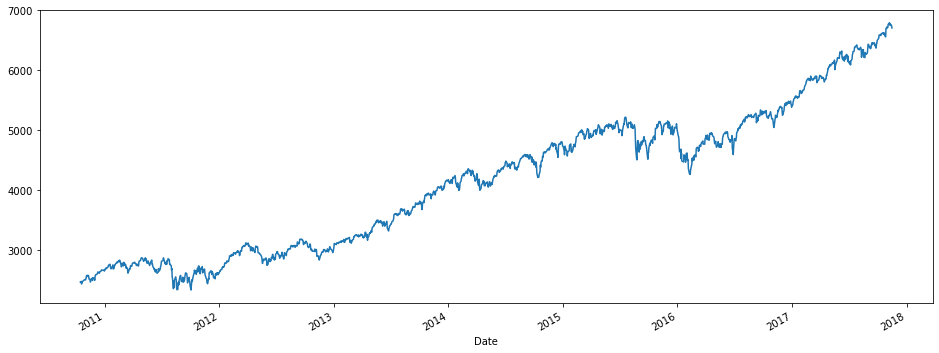

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

dataDF['Close'].plot()

<ipython-input-6-a6f7a5774cbf>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_close, model='multiplicative', freq = 30)


<Figure size 1152x432 with 0 Axes>

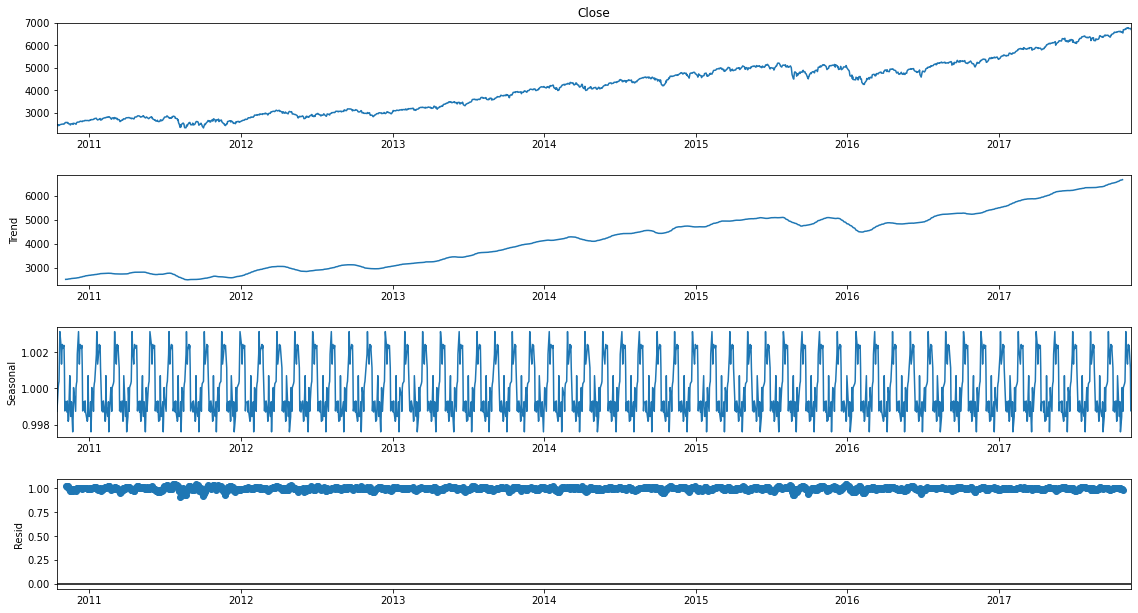

In [6]:
df_close = dataDF['Close']

result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

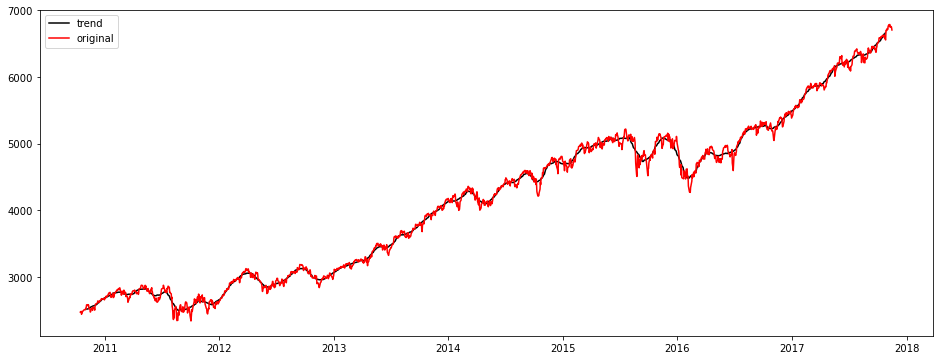

In [8]:
trend = result.trend.dropna()

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6


plt.plot(trend, color ="black", label = "trend")
plt.plot(df_close, color="red", label = "original")
plt.legend()
plt.show()

In [9]:
trendDF = pd.DataFrame(trend)
dataDF = pd.concat([dataDF, trendDF], axis = 1)

from datetime import timedelta

predict_days = 7 

dataDF['date_prediction'] = dataDF.index + timedelta(predict_days)
#index_shift = dataDF.index - timediff(predict_days)
label_col = dataDF[['trend']]
label_col.columns = ['predict_label']
label_col['date_prediction'] = label_col.index


dataDF['Date'] = dataDF.index
dataDF2 = pd.merge(dataDF, label_col, how = 'inner', on = 'date_prediction')
dataDF2.index = dataDF2['Date']
dataDF2 = dataDF2.drop(columns = ['Date'])

<ipython-input-9-d88615a584f9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_col['date_prediction'] = label_col.index


In [146]:
#dataDF2['trend'] = np.log10(dataDF2['trend'])
#dataDF2['predict_label'] = np.log10(dataDF2['predict_label'])

In [147]:
dataDF2[['trend', 'predict_label']].dropna()

,trend,predict_label
Date,,
2010-11-05,2514.818844,2530.478520
2010-11-08,2516.052511,2534.198018
2010-11-09,2518.220011,2537.856515
2010-11-10,2522.127348,2541.611178
2010-11-11,2526.356519,2545.670842
...,...,...
2017-10-12,6571.064469,6630.106966
2017-10-13,6581.560636,6639.299959
2017-10-16,6594.116805,6647.564290


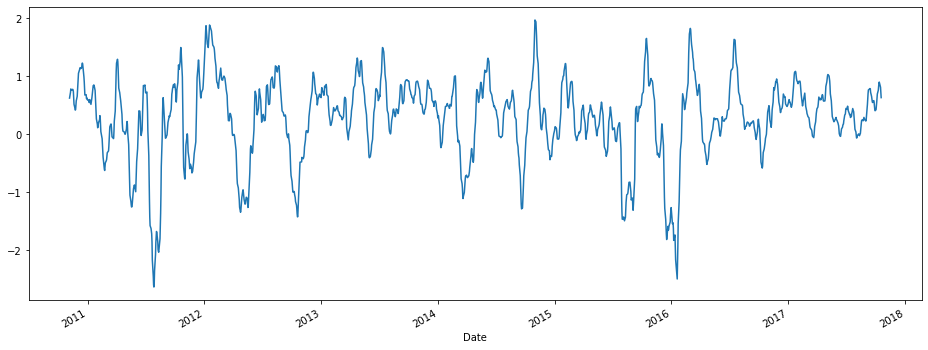

In [12]:
dataDF2['percent_label'] = 100*(dataDF2['predict_label'] - dataDF2['trend'])/dataDF2['trend']

dataDF2['percent_label'].plot(figsize = (16, 6))

In [13]:
feat_cols = [c for c in dataDF2.columns if (('label' not in c) & ('Name' != c) 
                                           & ('date_prediction' != c) & ('Close' != c) & ('trend' != c) & ('Volume' != c))]

feat_cols = [c for c in feat_cols if (('Close' not in c) & ('EMA' not in c))]
#feat_cols = ['ROC_10','ROC_15', 'ROC_5','DTB4WK','DTB6','DTB3','DE4','CTB3M','ROC_20','TE2','TE1','wheat-F','TE3','mom1','CNY','XOM','mom', 'RUT', 'NZD', 'RUSSELL-F']
label_col = ['percent_label']

feat_cols

['mom',
 'mom1',
 'mom2',
 'mom3',
 'ROC_5',
 'ROC_10',
 'ROC_15',
 'ROC_20',
 'DTB4WK',
 'DTB3',
 'DTB6',
 'DGS5',
 'DGS10',
 'Oil',
 'Gold',
 'DAAA',
 'DBAA',
 'GBP',
 'JPY',
 'CAD',
 'CNY',
 'AAPL',
 'AMZN',
 'GE',
 'JNJ',
 'JPM',
 'MSFT',
 'WFC',
 'XOM',
 'FCHI',
 'FTSE',
 'GDAXI',
 'GSPC',
 'HSI',
 'DJI',
 'SSEC',
 'RUT',
 'NYSE',
 'TE1',
 'TE2',
 'TE3',
 'TE5',
 'TE6',
 'DE1',
 'DE2',
 'DE4',
 'DE5',
 'DE6',
 'CTB3M',
 'CTB6M',
 'CTB1Y',
 'AUD',
 'Brent',
 'CAC-F',
 'copper-F',
 'WIT-oil',
 'DAX-F',
 'DJI-F',
 'EUR',
 'FTSE-F',
 'gold-F',
 'HSI-F',
 'KOSPI-F',
 'NASDAQ-F',
 'GAS-F',
 'Nikkei-F',
 'NZD',
 'silver-F',
 'RUSSELL-F',
 'S&P-F',
 'CHF',
 'Dollar index-F',
 'Dollar index',
 'wheat-F',
 'XAG',
 'XAU']

In [14]:
featDF = dataDF2[feat_cols + label_col].dropna()
featDF['label'] = featDF[label_col[0]]
featDF = featDF.drop(columns = label_col)

part = 0.70
train_data, test_data = featDF[3:int(len(featDF)*part)], featDF[int(len(featDF)*part):]

X = train_data.drop(columns = ['label'])
y = np.array(train_data['label'])
X_test = test_data.drop(columns = ['label'])
y_test = np.array(test_data['label'])

In [18]:
from sklearn import tree, ensemble, neighbors, neural_network





clf = ensemble.AdaBoostRegressor(base_estimator = tree.DecisionTreeRegressor(max_depth=7), n_estimators = 600)
#clf = ensemble.GradientBoostingRegressor(max_depth = 3, n_estimators = 400, learning_rate = 0.05, subsample = 0.7)

#high_clf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.9, learning_rate=0.05, n_estimators=100, subsample=0.7 )
#med_clf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.5, learning_rate=0.05, n_estimators=100, subsample=0.7 )
#low_clf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.1, learning_rate=0.05, n_estimators=100, subsample=0.7 )

#clf = ensemble.GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, subsample=0.5)

#clf = ensemble.GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, subsample=0.5)

#clf = neighbors.KNeighborsRegressor(n_neighbors = 30, weights = 'uniform', algorithm = 'kd_tree')
#clf = neural_network.MLPRegressor(max_iter = 200, alpha = 0.001)

#clf = ensemble.BaggingRegressor(base_estimator=neighbors.KNeighborsRegressor(n_neighbors = 10), max_samples = 0.4, n_estimators=100) #, random_state=0)
#clf = ensemble.BaggingRegressor(n_estimators=200) #, random_state=0)

#high_clf = high_clf.fit(X,y)
#med_clf = med_clf.fit(X,y)
#low_clf = low_clf.fit(X,y)

clf = clf.fit(X, y)

In [19]:
predict = clf.predict(X_test)
score = clf.score(X_test, y_test)
score

0.3135678747815568

In [161]:
high_predict = high_clf.predict(X_test)
high_score = high_clf.score(X_test, y_test)
high_score

med_predict = med_clf.predict(X_test)

med_score = med_clf.score(X_test, y_test)

low_predict = low_clf.predict(X_test)
low_score = low_clf.score(X_test, y_test)

[low_score, med_score, high_score]

[-1.4940255429309368, 0.19320688933627184, -0.5986032074305967]

No handles with labels found to put in legend.


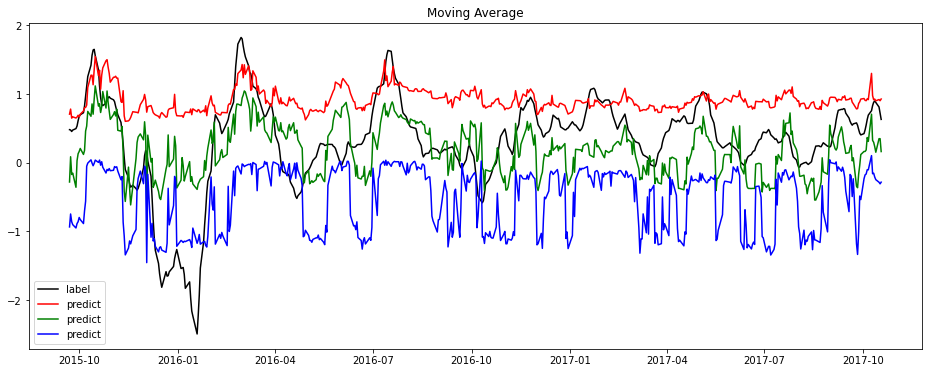

In [162]:
high_predictDF = pd.DataFrame(index = test_data.index, data = high_predict, columns = ['prediction'])
med_predictDF = pd.DataFrame(index = test_data.index, data = med_predict, columns = ['prediction'])
low_predictDF = pd.DataFrame(index = test_data.index, data = low_predict, columns = ['prediction'])

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

#original_label = featDF[int(len(featDF)*part):][test_data.index]

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(test_data['label'], color ="black", label = "label")
plt.plot(high_predictDF['prediction'], color="red", label = "predict")
plt.plot(med_predictDF['prediction'], color="green", label = "predict")
plt.plot(low_predictDF['prediction'], color="blue", label = "predict")
#plt.plot(original_label, color='green', label = 'original')
plt.legend()
plt.show()

No handles with labels found to put in legend.


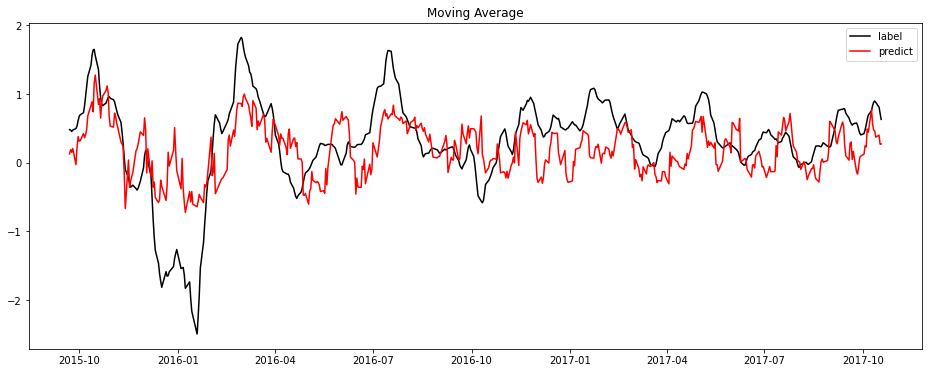

In [20]:
predictDF = pd.DataFrame(index = test_data.index, data = predict, columns = ['prediction'])

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

#original_label = featDF[int(len(featDF)*part):][test_data.index]

plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(test_data['label'], color ="black", label = "label")
plt.plot(predictDF['prediction'], color="red", label = "predict")
#plt.plot(original_label, color='green', label = 'original')
plt.legend()
plt.show()

In [21]:
from sklearn import model_selection 

tscv = model_selection.TimeSeriesSplit(n_splits = 4)

X_arr = np.array(X)

    
[clf.fit(X_arr[train], y[train]).score(X_arr[test], y[test]) for train, test in tscv.split(X_arr)]

[-0.02693436389607684,
 -7.161105282065325,
 0.31319660776692915,
 0.4123962175771223]

In [ ]:


#parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[5, 10, 20, 30]}

parameters = {'max_depth': [3, 5], 'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'subsample': [0.5, 0.7, 1.0]}
model =  ensemble.GradientBoostingRegressor()
clf = model_selection.GridSearchCV(model, parameters, cv = model_selection.TimeSeriesSplit(n_splits = 3))
 
clf.fit(X_arr, y)

In [ ]:
sorted(clf.cv_results_.keys())

In [137]:
clf.cv_results_

AttributeError: 'GradientBoostingRegressor' object has no attribute 'cv_results_'

In [ ]:
clf.cv_results_['std_test_score']

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_score_